We start by interpolating the thermophysical properties of the solid:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from deepxde.backend import tf
import seaborn as sns
sns.set_context('talk')
%matplotlib inline

import deepxde as dde

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



Defining the geometry of the powderbed:

In [2]:
dde.config.set_default_float("float64")
dde.config.set_random_seed(12345)

x_max = 1e-3
y_max = 0.23e-3
z_max = 0.1e-3

geo = dde.geometry.Hypercube((0.0, 0.0, 0.0), (x_max, y_max, z_max))

Set the default float type to float64


Defining the time and the domian:

In [3]:
t_max = 0.002

time = dde.geometry.TimeDomain(0, t_max)
domain = dde.geometry.GeometryXTime(geo, time)

Defining the other properties:

In [4]:
A = 0.09
D = 140e-6
R = D/2
P = 250
v = 200e-3
T_0 = 273.15

Defining the top boundary neglecting the convection and radiation:

defining the pde system:

In [5]:
def pde_system(X, output):
    
    T = output
    
    dT_dx = dde.grad.jacobian(T, X, j = 0)
    dT_dy = dde.grad.jacobian(T, X, j = 1)
    dT_dz = dde.grad.jacobian(T, X, j = 2)
    dT_dt = dde.grad.jacobian(T, X, j = 3)
    
    molten = T > 1693
    
    k = (11.82+1.06e-2*T)
    c = (330.9+0.563*T-4.015e-4*T**2+9.465e-8*T**3)
    rho = 7800.0*T**0
    
    k_eff = tf.where(molten, k, 0.6*k)
    rho_eff = tf.where(molten, rho, 0.6*rho)
    
    diff_T = dde.grad.jacobian(k_eff*dT_dx, X, j = 0) + dde.grad.jacobian(k_eff*dT_dy, X, j=1) + dde.grad.jacobian(k_eff*dT_dz, X, j = 2)
    
    f_T = dT_dt - diff_T/(rho_eff*c)# + 272e3/(c**2*rho)*tf.cast(molten, 'float64')
        
    return f_T

def dummy(X, output):
    return output

Defining initial and boundary conditions:

In [6]:
def top_bc(X, Y):
    
    molten = Y > 1693
    r_sq = (X[:,0:1] - x_max/4 - X[:,3:4]*v)**2 + (X[:,1:2] - y_max/2)**2
    k = (11.82+1.06e-2*Y)
    k_eff =  k_eff = tf.where(molten, k, 0.6*k)
    return 2*A*P/(np.pi*R**2)*tf.exp(-2*r_sq/R**2)/k_eff

ic = dde.icbc.IC(domain, lambda on_initial: 20.0 + T_0, lambda x, on_initial: on_initial and not np.isclose(x[2], z_max, atol=z_max/20))
#top = dde.icbc.NeumannBC(domain, top_bc(x), lambda on_boundary, x: on_boundary and np.isclose(x[2], z))
top = dde.icbc.RobinBC(domain, lambda X, Y : top_bc(X, Y), lambda x, on_boundary: on_boundary and np.isclose(x[2], z_max, atol=z_max/20))
sides = dde.icbc.DirichletBC(domain, lambda X : 20.0 + T_0, lambda x, on_boundary: on_boundary and not np.isclose(x[2], z_max, atol=z_max/20))

creating the dataset:

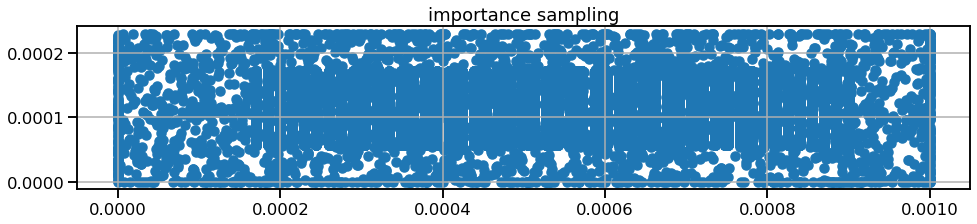

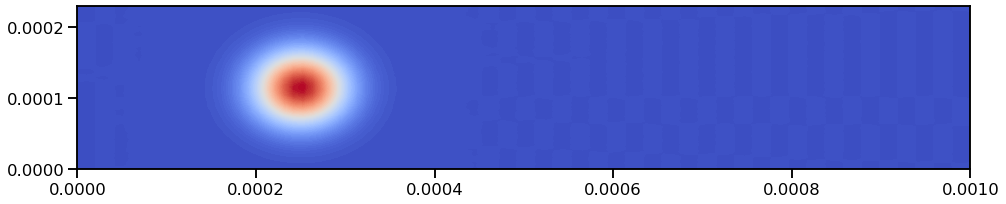

In [7]:
#setting training points at the important part of the boundary
x_lin = np.linspace(0.17*x_max, 0.9*x_max, 25)
y_lin = np.linspace(0.25*y_max, 0.75*y_max, 10)
z_lin = np.linspace(0.5*z_max, 0.95*z_max, 4)
t_lin = np.linspace(0.1*t_max, t_max, 10)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, z_lin, t_lin)
X_int = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

x_lin_bound = np.linspace(0.17*x_max, 0.9*x_max, 50)
y_lin_bound = np.linspace(0.25*y_max, 0.75*y_max, 20)
xx_bound, yy_bound, zz_bound, tt_bound = np.meshgrid(x_lin_bound, y_lin_bound, z_max, t_lin)
X_bound = np.vstack((np.ravel(xx_bound), np.ravel(yy_bound), np.ravel(zz_bound), np.ravel(tt_bound))).T

X = np.concatenate([X_int, X_bound])

data = dde.data.TimePDE(domain,
                       pde_system,
                       ic_bcs = [top, sides, ic],
                       num_domain = 1000,
                       num_initial = 1000,
                       num_boundary = 1000,
                       train_distribution="pseudo",
                       num_test = 1e4,
                       anchors=X)

points = data.train_points().T
    
plt.figure(figsize = (16, 3))
plt.scatter(points[0], points[1])
#plt.colorbar()
plt.title('importance sampling')
plt.grid()

def top_bc_test(X):
    
    r_sq = (X[:,0:1] - x_max/4 - X[:,3:4]*v)**2 + (X[:,1:2] - y_max/2)**2
    return 2*A*P/(np.pi*R**2)*np.exp(-2*r_sq/R**2)

x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [0])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T
xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
plot_data = griddata((np.ravel(xx), np.ravel(yy)), top_bc_test(X)[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (16, 3))
plt.contourf(xi, yi, plot_data, 100, cmap=plt.cm.coolwarm)
#plt.colorbar()

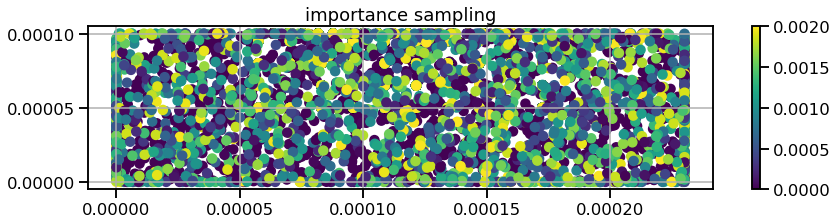

In [8]:
plt.figure(figsize = (14, 3))
plt.scatter(points[1], points[2], c = points[3])
plt.colorbar()
plt.title('importance sampling')
plt.grid()

In [9]:
#net = dde.nn.FNN([4] + [50] * 20 + [1], "sin", "Glorot normal")
#activation = f"LAAF-{1} sin" 
net = dde.nn.MsFFN([4] + [20] * 10 + [1], 'sin', "Glorot normal", sigmas = [1])

def feature_transform(X):
    return tf.concat(
        [X[:, 0:1]/x_max, 
         X[:, 1:2]/y_max,
         X[:, 2:3]/z_max,
         X[:, 3:4]/t_max], axis=1
    )
net.apply_feature_transform(feature_transform)

def modify_output(X, Y):
    x, y, z, t = X[:, 0:1], X[:, 1:2], X[:, 2:3], X[:, 3:4]
    Temperature = Y
    T_new = 20.0 + T_0 + Temperature*3000
    return tf.concat(T_new, axis = 1)
net.apply_output_transform(modify_output)

model = dde.Model(data, net)
model.compile("adam", lr=1e-5)

Compiling model...
Building Multiscale Fourier Feature Network...


/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
2022-07-08 10:19:22.673539: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 10:19:22.694684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 10:19:22.694983: I tensorflow/stream_execu

'compile' took 2.691819 s



In [10]:
losshistory, train_state = model.train(epochs=0, display_every=1000, batch_size = 2000)
weights = 1/np.array(losshistory.loss_train[0])
weights_2 = np.array([1, 1, 1])
resampler = dde.callbacks.PDEResidualResampler(100)

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.89e+18, 2.70e+15, 4.74e+05, 5.83e+05]    [1.02e+15, 2.70e+15, 4.74e+05, 5.83e+05]    []  

Best model at step 0:
  train loss: 3.89e+18
  test loss: 3.72e+15
  test metric: []

'train' took 1.202142 s



In [11]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-30, gtol=1e-30, maxiter=2000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2, 1])
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100, callbacks = [resampler], batch_size = 100)

Compiling model...
'compile' took 1.875120 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [5.07e-05, 1.90e+02, 1.10e+02, 1.18e+00]    [8.22e-04, 1.90e+02, 1.10e+02, 1.18e+00]    []  
100       [2.40e-05, 2.64e+01, 5.49e+00, 9.78e-02]                                                    
200       [2.40e-05, 2.65e+01, 5.49e+00, 9.78e-02]                                                    
300       [1.04e-05, 2.65e+01, 5.35e+00, 9.93e-02]                                                    
400       [1.04e-05, 2.65e+01, 5.35e+00, 9.93e-02]                                                    
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 31.939963
  Number of iterations: 42
  Number of functions evaluations: 442
442       [1.04e-05, 2.65e+01, 5.35e+00, 9.93e-02]    [2.52e-07, 2.65e+01, 

In [12]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2, 1])
model.compile('adam',lr = 1e-3, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 1000, display_every=100, callbacks = [resampler], batch_size = 4000)

Compiling model...
'compile' took 2.355880 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
442       [1.04e-05, 2.65e+01, 5.35e+00, 9.93e-02]    [2.52e-07, 2.65e+01, 5.35e+00, 9.93e-02]    []  
500       [9.97e-02, 9.46e+01, 2.86e+02, 1.75e+00]    [2.23e-07, 9.46e+01, 2.86e+02, 1.75e+00]    []  
600       [2.57e-02, 2.91e+02, 4.20e+02, 3.35e+00]    [1.10e+01, 2.91e+02, 4.20e+02, 3.35e+00]    []  
700       [2.52e-02, 2.91e+02, 4.20e+02, 3.35e+00]    [7.65e+00, 2.91e+02, 4.20e+02, 3.35e+00]    []  
800       [3.31e-02, 2.91e+02, 4.20e+02, 3.35e+00]    [7.65e+00, 2.91e+02, 4.20e+02, 3.35e+00]    []  
900       [2.94e-02, 2.91e+02, 4.20e+02, 3.35e+00]    [7.65e+00, 2.91e+02, 4.20e+02, 3.35e+00]    []  
1000      [2.60e-02, 2.91e+02, 4.20e+02, 3.35e+00]    [7.65e+00, 2.91e+02, 4.20e+02, 3.35e+00]    []  
1100      [1.71e+01, 2.91e+02, 4.20e+02, 3.35e+00]    [6.07e+00, 2.91e+02, 4.20e+02, 3.35e+00]    []  
1

In [17]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-30, gtol=1e-30, maxiter=2000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2, 1])
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100, callbacks = [resampler], batch_size = 100)

Compiling model...
'compile' took 2.257146 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
1442      [2.12e+00, 2.91e+02, 4.20e+02, 3.35e+00]    [5.37e+00, 2.91e+02, 4.20e+02, 3.35e+00]    []  
1500      [2.84e-04, 9.34e+00, 2.18e+00, 2.11e-02]                                                    
1600      [1.92e-04, 3.59e-01, 6.61e-02, 2.68e-03]                                                    
1700      [1.87e-04, 2.49e-01, 2.93e-02, 2.31e-03]                                                    
1800      [1.87e-04, 2.49e-01, 2.93e-02, 2.31e-03]                                                    
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.281249
  Number of iterations: 173
  Number of functions evaluations: 450
1892      [1.87e-04, 2.49e-01, 2.93e-02, 2.31e-03]    [1.07e-07, 2.49e-01, 2.93e-02, 2.31e-03]    [] 

In [18]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2, 1])
model.compile('adam',lr = 1e-4, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 2000, display_every=100, callbacks = [resampler], batch_size = 4000)

Compiling model...
'compile' took 2.829072 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
1892      [1.87e-04, 2.49e-01, 2.93e-02, 2.31e-03]    [1.07e-07, 2.49e-01, 2.93e-02, 2.31e-03]    []  
1900      [1.86e-04, 3.16e-01, 3.85e-02, 2.39e-03]    [1.14e-07, 3.16e-01, 3.85e-02, 2.39e-03]    []  
2000      [1.86e-04, 2.41e-01, 2.25e-02, 2.36e-03]    [8.92e-08, 2.41e-01, 2.25e-02, 2.36e-03]    []  
2100      [1.86e-04, 2.24e-01, 1.96e-02, 2.32e-03]    [7.02e-08, 2.24e-01, 1.96e-02, 2.32e-03]    []  
2200      [1.87e-04, 2.25e-01, 1.76e-02, 2.25e-03]    [5.60e-08, 2.25e-01, 1.76e-02, 2.25e-03]    []  
2300      [1.85e-04, 2.27e-01, 1.61e-02, 2.21e-03]    [4.78e-08, 2.27e-01, 1.61e-02, 2.21e-03]    []  
2400      [1.84e-04, 2.16e-01, 1.48e-02, 2.17e-03]    [4.38e-08, 2.16e-01, 1.48e-02, 2.17e-03]    []  
2500      [1.78e-04, 2.04e-01, 1.39e-02, 2.10e-03]    [4.17e-08, 2.04e-01, 1.39e-02, 2.10e-03]    []  
2

In [27]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-30, gtol=1e-30, maxiter=2000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2, 1])
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100, callbacks = [resampler], batch_size = 100)

Compiling model...
'compile' took 2.485021 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
3892      [8.77e-05, 4.17e-01, 1.76e-02, 5.30e-03]    [6.50e-07, 4.17e-01, 1.76e-02, 5.30e-03]    []  
3900      [8.77e-05, 4.17e-01, 1.76e-02, 5.30e-03]                                                    
4000      [8.77e-05, 4.12e-01, 1.77e-02, 5.39e-03]                                                    
4100      [8.73e-05, 4.09e-01, 1.83e-02, 5.59e-03]                                                    
4200      [8.73e-05, 4.09e-01, 1.83e-02, 5.58e-03]                                                    
4300      [8.68e-05, 4.08e-01, 1.81e-02, 5.55e-03]                                                    
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.430880
  Number of iterations: 36
  Number of functions evaluations: 499

In [28]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2, 1])
model.compile('adam',lr = 1e-5, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 10000, display_every=100, callbacks = [resampler], batch_size = 4000)

Compiling model...
'compile' took 3.227482 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
4391      [8.68e-05, 4.07e-01, 1.81e-02, 5.55e-03]    [6.92e-07, 4.07e-01, 1.81e-02, 5.55e-03]    []  
4400      [8.66e-05, 4.09e-01, 1.86e-02, 5.57e-03]    [6.85e-07, 4.09e-01, 1.86e-02, 5.57e-03]    []  
4500      [8.52e-05, 4.06e-01, 1.79e-02, 5.47e-03]    [6.89e-07, 4.06e-01, 1.79e-02, 5.47e-03]    []  
4600      [8.40e-05, 4.09e-01, 1.80e-02, 5.56e-03]    [7.14e-07, 4.09e-01, 1.80e-02, 5.56e-03]    []  
4700      [8.21e-05, 4.02e-01, 1.81e-02, 5.71e-03]    [7.40e-07, 4.02e-01, 1.81e-02, 5.71e-03]    []  
4800      [7.90e-05, 4.04e-01, 1.84e-02, 5.92e-03]    [7.71e-07, 4.04e-01, 1.84e-02, 5.92e-03]    []  
4900      [7.66e-05, 4.02e-01, 1.87e-02, 6.06e-03]    [8.11e-07, 4.02e-01, 1.87e-02, 6.06e-03]    []  
5000      [7.36e-05, 3.98e-01, 1.90e-02, 6.30e-03]    [8.44e-07, 3.98e-01, 1.90e-02, 6.30e-03]    []  
5

12100     [1.43e-05, 4.65e-02, 3.07e-03, 7.94e-03]    [3.02e-06, 4.65e-02, 3.07e-03, 7.94e-03]    []  
12200     [1.46e-05, 4.58e-02, 3.02e-03, 7.81e-03]    [3.00e-06, 4.58e-02, 3.02e-03, 7.81e-03]    []  
12300     [1.48e-05, 4.55e-02, 2.98e-03, 7.64e-03]    [3.00e-06, 4.55e-02, 2.98e-03, 7.64e-03]    []  
12400     [1.49e-05, 4.37e-02, 2.92e-03, 7.71e-03]    [3.03e-06, 4.37e-02, 2.92e-03, 7.71e-03]    []  
12500     [1.50e-05, 4.33e-02, 2.84e-03, 7.74e-03]    [2.93e-06, 4.33e-02, 2.84e-03, 7.74e-03]    []  
12600     [1.52e-05, 4.28e-02, 2.77e-03, 7.55e-03]    [2.89e-06, 4.28e-02, 2.77e-03, 7.55e-03]    []  
12700     [1.53e-05, 4.24e-02, 2.72e-03, 7.39e-03]    [2.86e-06, 4.24e-02, 2.72e-03, 7.39e-03]    []  
12800     [1.56e-05, 4.20e-02, 2.68e-03, 7.14e-03]    [2.84e-06, 4.20e-02, 2.68e-03, 7.14e-03]    []  
12900     [1.57e-05, 4.16e-02, 2.64e-03, 7.00e-03]    [2.80e-06, 4.16e-02, 2.64e-03, 7.00e-03]    []  
13000     [1.60e-05, 4.07e-02, 2.59e-03, 7.03e-03]    [2.78e-06, 4.07e-02

In [36]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-30, gtol=1e-30, maxiter=2000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2, 1])
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100, callbacks = [resampler], batch_size = 100)

Compiling model...
'compile' took 2.784726 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
14391     [1.95e-05, 3.32e-02, 2.29e-03, 6.15e-03]    [2.20e-06, 3.32e-02, 2.29e-03, 6.15e-03]    []  
14400     [1.95e-05, 3.32e-02, 2.29e-03, 6.14e-03]                                                    
14500     [1.95e-05, 3.54e-02, 2.29e-03, 6.14e-03]                                                    
14600     [1.95e-05, 3.54e-02, 2.29e-03, 6.14e-03]                                                    
14700     [1.95e-05, 3.32e-02, 2.29e-03, 6.14e-03]                                                    
14800     [1.95e-05, 3.54e-02, 2.29e-03, 6.14e-03]                                                    
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.041617
  Number of iterations: 20
  Number of functions evaluations: 438

In [37]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2, 1])
model.compile('adam',lr = 5e-6, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 5000, display_every=100, callbacks = [resampler], batch_size = 4000)

Compiling model...
'compile' took 3.132829 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
14829     [1.95e-05, 3.32e-02, 2.29e-03, 6.14e-03]    [2.20e-06, 3.32e-02, 2.29e-03, 6.14e-03]    []  
14900     [1.95e-05, 3.30e-02, 2.28e-03, 6.13e-03]    [2.18e-06, 3.30e-02, 2.28e-03, 6.13e-03]    []  
15000     [2.01e-05, 3.30e-02, 2.27e-03, 6.09e-03]    [2.15e-06, 3.30e-02, 2.27e-03, 6.09e-03]    []  
15100     [2.03e-05, 3.50e-02, 2.25e-03, 6.05e-03]    [2.12e-06, 3.50e-02, 2.25e-03, 6.05e-03]    []  
15200     [2.03e-05, 3.47e-02, 2.24e-03, 6.02e-03]    [2.10e-06, 3.47e-02, 2.24e-03, 6.02e-03]    []  
15300     [2.03e-05, 3.46e-02, 2.22e-03, 5.98e-03]    [2.08e-06, 3.46e-02, 2.22e-03, 5.98e-03]    []  
15400     [2.06e-05, 3.22e-02, 2.21e-03, 5.96e-03]    [2.07e-06, 3.22e-02, 2.21e-03, 5.96e-03]    []  
15500     [2.07e-05, 3.41e-02, 2.19e-03, 5.92e-03]    [2.05e-06, 3.41e-02, 2.19e-03, 5.92e-03]    []  
1

In [46]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
weights_2 = np.array([1, 1e2, 1e2, 1])
model.compile('adam',lr = 5e-6, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 5000, display_every=100, callbacks = [resampler], batch_size = 5000)

Compiling model...
'compile' took 3.960788 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
19829     [3.04e-05, 2.67e-02, 1.68e-03, 4.59e-03]    [1.53e-06, 2.67e-02, 1.68e-03, 4.59e-03]    []  
19900     [3.05e-05, 2.67e-02, 1.68e-03, 4.58e-03]    [1.52e-06, 2.67e-02, 1.68e-03, 4.58e-03]    []  
20000     [3.05e-05, 2.66e-02, 1.67e-03, 4.56e-03]    [1.52e-06, 2.66e-02, 1.67e-03, 4.56e-03]    []  
20100     [3.05e-05, 2.65e-02, 1.66e-03, 4.53e-03]    [1.51e-06, 2.65e-02, 1.66e-03, 4.53e-03]    []  
20200     [3.08e-05, 2.61e-02, 1.66e-03, 4.55e-03]    [1.52e-06, 2.61e-02, 1.66e-03, 4.55e-03]    []  
20300     [3.10e-05, 2.60e-02, 1.65e-03, 4.51e-03]    [1.51e-06, 2.60e-02, 1.65e-03, 4.51e-03]    []  
20400     [3.16e-05, 2.59e-02, 1.63e-03, 4.46e-03]    [1.51e-06, 2.59e-02, 1.63e-03, 4.46e-03]    []  
20500     [3.15e-05, 2.58e-02, 1.62e-03, 4.39e-03]    [1.50e-06, 2.58e-02, 1.62e-03, 4.39e-03]    []  
2

In [69]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
weights_2 = np.array([1e2, 1e2, 1e2, 1])
model.compile('adam',lr = 5e-6, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 5000, display_every=100, callbacks = [resampler], batch_size = 5000)

Compiling model...
'compile' took 3.439844 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
24829     [4.93e-03, 1.78e-02, 1.11e-03, 2.54e-03]    [1.84e-04, 1.78e-02, 1.11e-03, 2.54e-03]    []  
24900     [4.81e-03, 1.81e-02, 1.11e-03, 2.43e-03]    [1.77e-04, 1.81e-02, 1.11e-03, 2.43e-03]    []  
25000     [4.73e-03, 1.85e-02, 1.10e-03, 2.39e-03]    [1.72e-04, 1.85e-02, 1.10e-03, 2.39e-03]    []  
25100     [4.45e-03, 1.85e-02, 1.10e-03, 2.41e-03]    [1.72e-04, 1.85e-02, 1.10e-03, 2.41e-03]    []  
25200     [4.32e-03, 1.86e-02, 1.09e-03, 2.41e-03]    [1.72e-04, 1.86e-02, 1.09e-03, 2.41e-03]    []  
25300     [4.24e-03, 1.86e-02, 1.09e-03, 2.43e-03]    [1.72e-04, 1.86e-02, 1.09e-03, 2.43e-03]    []  
25400     [4.09e-03, 1.87e-02, 1.09e-03, 2.44e-03]    [1.74e-04, 1.87e-02, 1.09e-03, 2.44e-03]    []  
25500     [3.96e-03, 1.89e-02, 1.09e-03, 2.45e-03]    [1.75e-04, 1.89e-02, 1.09e-03, 2.45e-03]    []  
2

In [78]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
weights_2 = np.array([1e2, 1e2, 1e2, 1])
model.compile('adam',lr = 1e-6, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 5000, display_every=100, callbacks = [resampler], batch_size = 5000)

Compiling model...
'compile' took 3.592891 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
29829     [2.16e-03, 1.53e-02, 9.32e-04, 1.65e-03]    [4.54e-04, 1.53e-02, 9.32e-04, 1.65e-03]    []  
29900     [2.16e-03, 1.53e-02, 9.31e-04, 1.65e-03]    [4.56e-04, 1.53e-02, 9.31e-04, 1.65e-03]    []  
30000     [2.19e-03, 1.53e-02, 9.30e-04, 1.64e-03]    [4.58e-04, 1.53e-02, 9.30e-04, 1.64e-03]    []  
30100     [2.18e-03, 1.52e-02, 9.28e-04, 1.64e-03]    [4.61e-04, 1.52e-02, 9.28e-04, 1.64e-03]    []  
30200     [2.16e-03, 1.52e-02, 9.25e-04, 1.63e-03]    [4.65e-04, 1.52e-02, 9.25e-04, 1.63e-03]    []  
30300     [2.16e-03, 1.52e-02, 9.23e-04, 1.62e-03]    [4.68e-04, 1.52e-02, 9.23e-04, 1.62e-03]    []  
30400     [2.15e-03, 1.51e-02, 9.21e-04, 1.62e-03]    [4.73e-04, 1.51e-02, 9.21e-04, 1.62e-03]    []  
30500     [2.14e-03, 1.51e-02, 9.18e-04, 1.61e-03]    [4.76e-04, 1.51e-02, 9.18e-04, 1.61e-03]    []  
3

In [85]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-30, gtol=1e-30, maxiter=2000, maxfun=None, maxls=50)
weights_2 = np.array([1e2, 1e2, 1e2, 1])
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100, callbacks = [resampler], batch_size = 100)

Compiling model...
'compile' took 3.903839 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
34829     [1.84e-03, 1.35e-02, 8.32e-04, 1.30e-03]    [6.89e-04, 1.35e-02, 8.32e-04, 1.30e-03]    []  
34900     [1.63e-03, 1.29e-02, 9.28e-04, 1.07e-03]                                                    
35000     [1.63e-03, 1.29e-02, 9.28e-04, 1.07e-03]                                                    
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.016492
  Number of iterations: 40
  Number of functions evaluations: 263
35092     [1.63e-03, 1.29e-02, 9.28e-04, 1.07e-03]    [9.36e-04, 1.29e-02, 9.28e-04, 1.07e-03]    []  

Best model at step 35092:
  train loss: 1.65e-02
  test loss: 1.58e-02
  test metric: []

'train' took 88.131877 s



In [86]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
weights_2 = np.array([1e2, 1e2, 1e2, 1])
model.compile('adam',lr = 1e-6, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 5000, display_every=100, callbacks = [resampler], batch_size = 5000)

Compiling model...
'compile' took 4.337708 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
35092     [1.63e-03, 1.29e-02, 9.28e-04, 1.07e-03]    [9.36e-04, 1.29e-02, 9.28e-04, 1.07e-03]    []  
35100     [1.63e-03, 1.34e-02, 9.19e-04, 1.09e-03]    [9.39e-04, 1.34e-02, 9.19e-04, 1.09e-03]    []  
35200     [1.60e-03, 1.28e-02, 8.76e-04, 1.19e-03]    [9.66e-04, 1.28e-02, 8.76e-04, 1.19e-03]    []  
35300     [1.61e-03, 1.27e-02, 8.61e-04, 1.22e-03]    [9.71e-04, 1.27e-02, 8.61e-04, 1.22e-03]    []  
35400     [1.60e-03, 1.26e-02, 8.49e-04, 1.23e-03]    [9.70e-04, 1.26e-02, 8.49e-04, 1.23e-03]    []  
35500     [1.58e-03, 1.25e-02, 8.41e-04, 1.24e-03]    [9.73e-04, 1.25e-02, 8.41e-04, 1.24e-03]    []  
35600     [1.58e-03, 1.25e-02, 8.34e-04, 1.25e-03]    [9.77e-04, 1.25e-02, 8.34e-04, 1.25e-03]    []  
35700     [1.56e-03, 1.25e-02, 8.27e-04, 1.25e-03]    [9.78e-04, 1.25e-02, 8.27e-04, 1.25e-03]    []  
3

In [87]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-30, gtol=1e-30, maxiter=2000, maxfun=None, maxls=50)
weights_2 = np.array([1e2, 1e2, 1e2, 1])
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100, callbacks = [resampler], batch_size = 100)

Compiling model...
'compile' took 4.025648 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
40092     [1.33e-03, 1.16e-02, 6.65e-04, 1.07e-03]    [1.09e-03, 1.16e-02, 6.65e-04, 1.07e-03]    []  
40100     [1.33e-03, 1.16e-02, 6.64e-04, 1.07e-03]                                                    
40200     [1.29e-03, 1.13e-02, 6.48e-04, 9.71e-04]                                                    
40300     [1.27e-03, 1.12e-02, 6.49e-04, 9.29e-04]                                                    
40400     [1.26e-03, 1.10e-02, 6.34e-04, 9.60e-04]                                                    
40500     [1.24e-03, 1.07e-02, 6.69e-04, 1.06e-03]                                                    
40600     [1.23e-03, 1.09e-02, 6.36e-04, 1.16e-03]                                                    
40700     [1.23e-03, 1.05e-02, 6.36e-04, 1.16e-03]                                                    
4

In [99]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
weights_2 = np.array([1e2, 1e2, 1e2, 1])
model.compile('adam',lr = 5e-7, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 5000, display_every=100, callbacks = [resampler], batch_size = 5000)

Compiling model...
'compile' took 4.371916 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
41024     [1.23e-03, 1.05e-02, 6.36e-04, 1.16e-03]    [1.37e-03, 1.05e-02, 6.36e-04, 1.16e-03]    []  
41100     [1.22e-03, 1.05e-02, 6.40e-04, 1.29e-03]    [1.39e-03, 1.05e-02, 6.40e-04, 1.29e-03]    []  
41200     [1.22e-03, 1.00e-02, 6.40e-04, 1.39e-03]    [1.41e-03, 1.00e-02, 6.40e-04, 1.39e-03]    []  
41300     [1.24e-03, 9.65e-03, 6.36e-04, 1.46e-03]    [1.42e-03, 9.65e-03, 6.36e-04, 1.46e-03]    []  
41400     [1.25e-03, 9.52e-03, 6.31e-04, 1.48e-03]    [1.42e-03, 9.52e-03, 6.31e-04, 1.48e-03]    []  
41500     [1.24e-03, 9.45e-03, 6.27e-04, 1.49e-03]    [1.42e-03, 9.45e-03, 6.27e-04, 1.49e-03]    []  
41600     [1.25e-03, 9.40e-03, 6.24e-04, 1.48e-03]    [1.41e-03, 9.40e-03, 6.24e-04, 1.48e-03]    []  
41700     [1.24e-03, 9.41e-03, 6.21e-04, 1.47e-03]    [1.41e-03, 9.41e-03, 6.21e-04, 1.47e-03]    []  
4

In [108]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=1000, maxfun=None, maxls=50)
weights_2 = np.array([1e2, 1e2, 1e2, 1])
model.compile('adam',lr = 5e-7, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 5000, display_every=100, callbacks = [resampler], batch_size = 5000)

Compiling model...
'compile' took 4.724361 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
46024     [1.13e-03, 9.16e-03, 5.28e-04, 1.18e-03]    [1.30e-03, 9.16e-03, 5.28e-04, 1.18e-03]    []  
46100     [1.13e-03, 9.15e-03, 5.27e-04, 1.17e-03]    [1.30e-03, 9.15e-03, 5.27e-04, 1.17e-03]    []  
46200     [1.14e-03, 9.15e-03, 5.26e-04, 1.16e-03]    [1.30e-03, 9.15e-03, 5.26e-04, 1.16e-03]    []  
46300     [1.12e-03, 9.14e-03, 5.25e-04, 1.15e-03]    [1.30e-03, 9.14e-03, 5.25e-04, 1.15e-03]    []  
46400     [1.11e-03, 9.13e-03, 5.23e-04, 1.14e-03]    [1.30e-03, 9.13e-03, 5.23e-04, 1.14e-03]    []  
46500     [1.13e-03, 9.12e-03, 5.22e-04, 1.13e-03]    [1.30e-03, 9.12e-03, 5.22e-04, 1.13e-03]    []  
46600     [1.12e-03, 9.12e-03, 5.21e-04, 1.12e-03]    [1.30e-03, 9.12e-03, 5.21e-04, 1.12e-03]    []  
46700     [1.11e-03, 9.11e-03, 5.19e-04, 1.11e-03]    [1.30e-03, 9.11e-03, 5.19e-04, 1.11e-03]    []  
4

In [117]:
model.save('soft/')

INFO:tensorflow:soft/-51024.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'soft/-51024.ckpt'

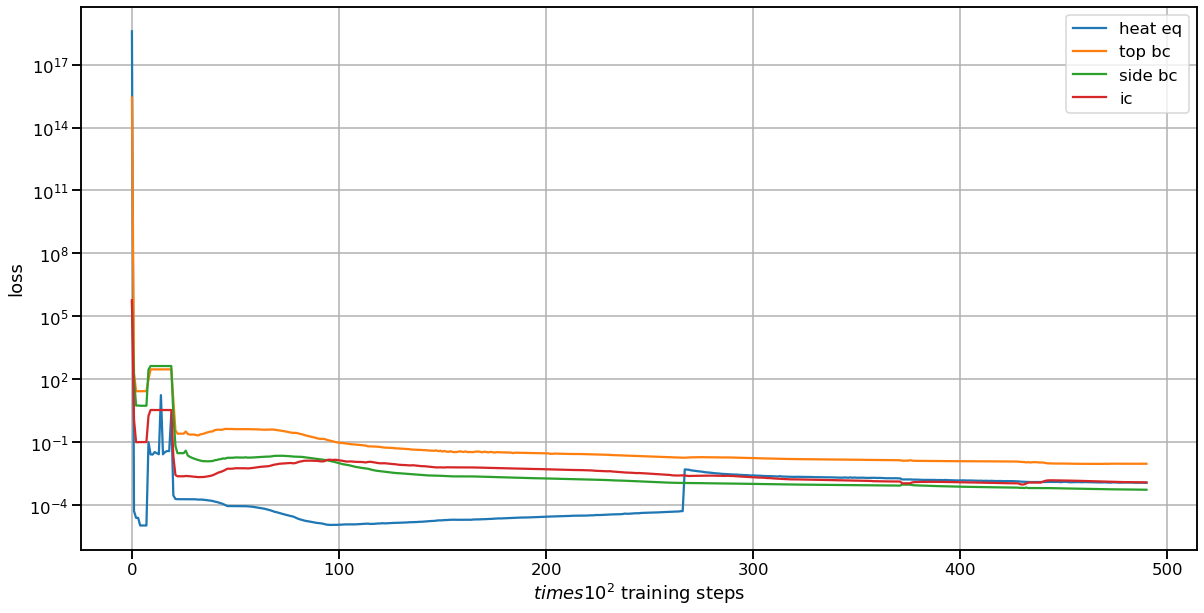

In [100]:
%matplotlib inline

loss_names = ['heat eq', 'top bc', 'side bc', 'ic']
n = 0
plt.figure(figsize = (20, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(loss[n:], label = name)

plt.yscale('log')
plt.xlabel(r'$ times 10^2$ training steps')
plt.ylabel('loss')
plt.grid()
plt.legend()

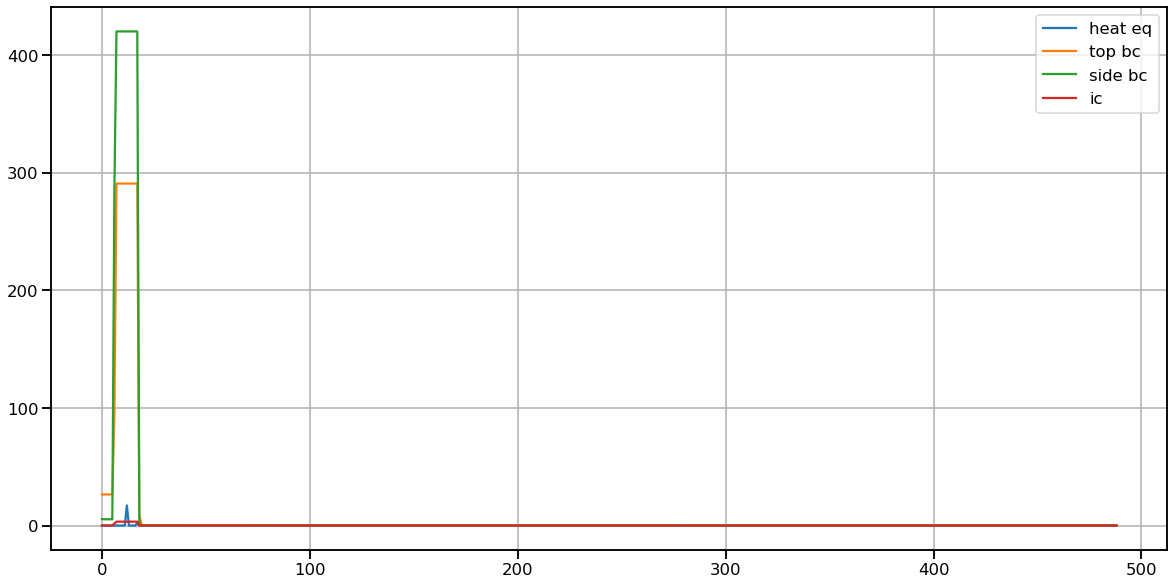

In [101]:
loss_names = ['heat eq', 'top bc', 'side bc', 'ic']
n = 2
plt.figure(figsize = (20, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(loss[n:], label = name)

plt.grid()
plt.legend()

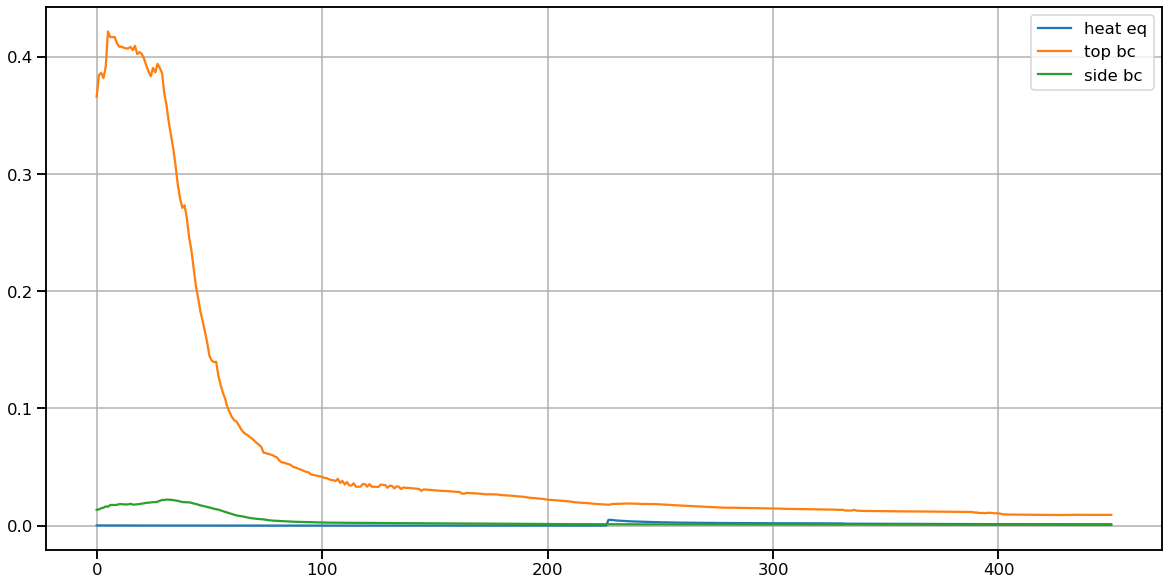

In [102]:
loss_names = ['heat eq', 'top bc', 'side bc']
n = 40
plt.figure(figsize = (20, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(loss[n:], label = name)

plt.grid()
plt.legend()

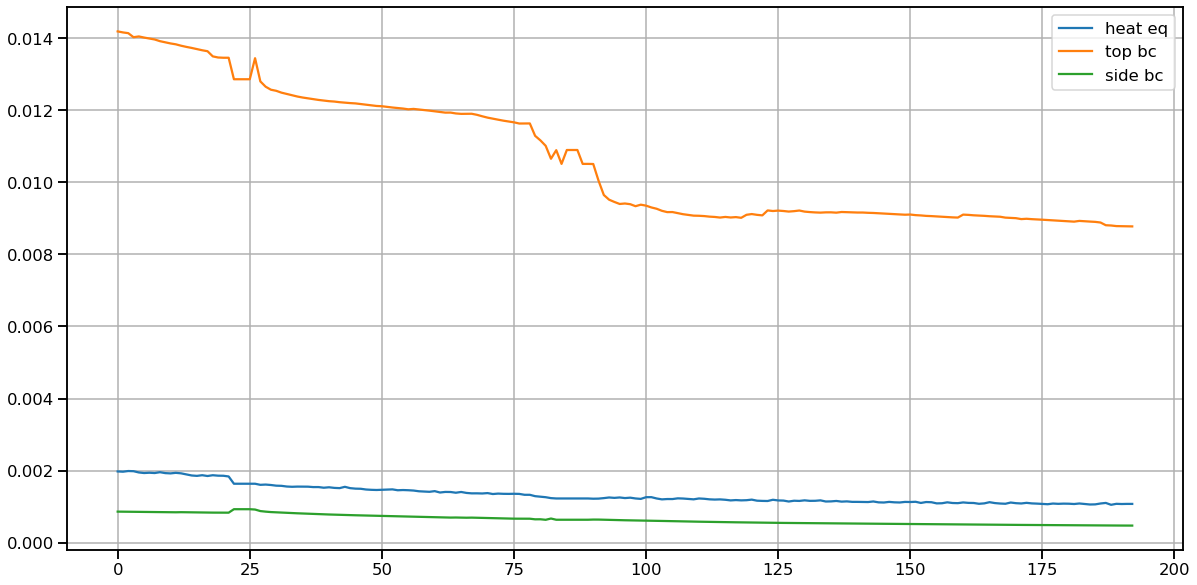

In [109]:
loss_names = ['heat eq', 'top bc', 'side bc']
n = 350
plt.figure(figsize = (20, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(loss[n:], label = name)

plt.grid()
plt.legend()

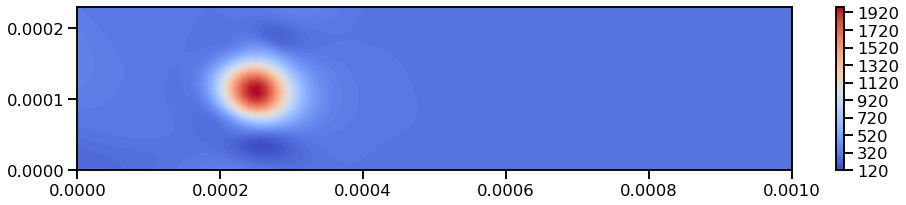

In [110]:
from scipy.interpolate import griddata

x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [0])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (16, 3))
plt.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm)
plt.colorbar()

<IPython.core.display.Javascript object>


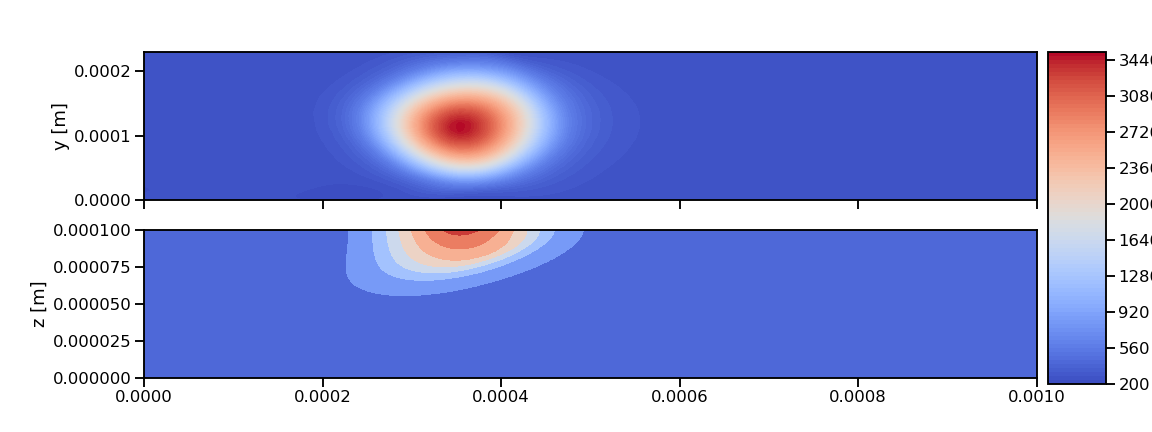

In [74]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook

fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (16, 6), sharex=True)

x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
z_lin = np.linspace(0, z_max)

xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T
Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

CS = ax1.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm)
ax1.set_ylabel('y [m]')
#plt.colorbar(CS, ax = ax1)

xx2, yy2, zz2, tt2 = np.meshgrid(x_lin, [y_max/2], z_lin, [t_max])
X2 = np.vstack((np.ravel(xx2), np.ravel(yy2), np.ravel(zz2), np.ravel(tt2))).T
Y2 = model.predict(X2)

xi2 = np.linspace(xx2.min(), xx2.max(), 100)
zi2 = np.linspace(zz2.min(), zz2.max(), 100)
data2 = griddata((np.ravel(xx2), np.ravel(zz2)), Y2[:,0], (xi2[None,:], zi2[:,None]), method='cubic')

CS2 = ax2.contourf(xi2, zi2, data2, 100, cmap=plt.cm.coolwarm)
ax2.set_ylabel('z [m]')
#plt.colorbar(CS2, ax = ax2)

cbar_ax = fig.add_axes([0.91, 0.11, 0.05, 0.77])
fig.colorbar(CS, cax=cbar_ax)

def animate(i):

    xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [i/100*t_max])
    X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T
    Y = model.predict(X)

    xi = np.linspace(xx.min(), xx.max(), 100)
    yi = np.linspace(yy.min(), yy.max(), 100)
    data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

    CS = ax1.contourf(xi, yi, data, 100, cmap=plt.cm.coolwarm)
    
    xx2, yy2, zz2, tt2 = np.meshgrid(x_lin, [y_max/2], z_lin, [i/100*t_max])
    X2 = np.vstack((np.ravel(xx2), np.ravel(yy2), np.ravel(zz2), np.ravel(tt2))).T
    Y2 = model.predict(X2)

    xi2 = np.linspace(xx2.min(), xx2.max(), 100)
    zi2 = np.linspace(zz2.min(), zz2.max(), 100)
    data2 = griddata((np.ravel(xx2), np.ravel(zz2)), Y2[:,0], (xi2[None,:], zi2[:,None]), method='cubic')

    CS2 = ax2.contourf(xi2, zi2, data2, intervall = 100, cmap=plt.cm.coolwarm)
            
FuncAnimation(fig, animate, frames = 100, interval=100)

<IPython.core.display.Javascript object>


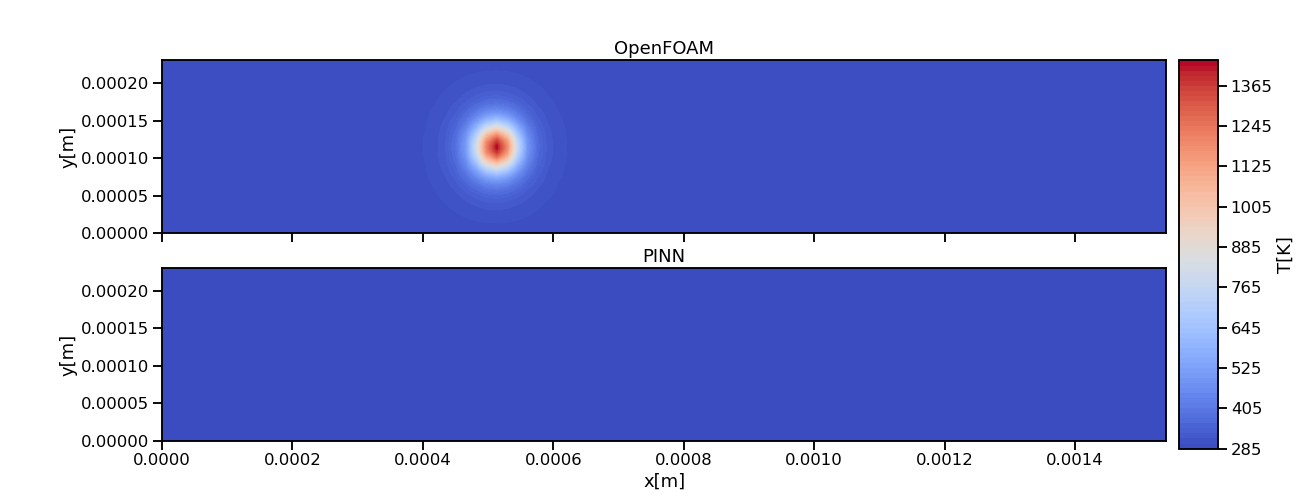

MovieWriter stderr:
pictures/video.mp4: No such file or directory



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1296x504', '-pix_fmt', 'rgba', '-r', '60', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'pictures/video.mp4']' returned non-zero exit status 1.

In [29]:
slice_data = np.genfromtxt('of_phase/slice1/slice_124.csv', delimiter = ',',skip_header = True)

x = slice_data[:,0]
y = slice_data[:,1]
z = slice_data[:,2]
T = slice_data[:,3]

fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (18, 7), sharex=True)

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')

im = ax1.contourf(xi, yi, Ti, 100, cmap=plt.cm.coolwarm)
ax1.set_ylabel('y[m]')
ax1.set_title('OpenFOAM')
ax2.set_ylabel('y[m]')
ax2.set_xlabel('x[m]')
ax2.set_title('PINN')

#cbar = plt.colorbar(im, ax = ax1)
#cbar.ax.set_ylabel('T[K]')
#cbar2 = plt.colorbar(im, ax = ax2)
#cbar2.ax.set_ylabel('T[K]')

cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('T[K]')

def animate(i):
    
    slice_data = np.genfromtxt('of_phase/slice1/slice_{}.csv'.format(i), delimiter = ',',skip_header = True)
    T = slice_data[:,3]
    
    #xx, yy, zz, tt = np.meshgrid(x, y, [z.max], [(i+1)/125*t_max])
    X = np.vstack((x, y, np.ones(len(x))*z.max(), np.ones(len(x))*t_max/125*(i+1))).T
    Y = model.predict(X)
    
    Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
    T_pred = griddata((x, y), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')
    
    im = ax1.contourf(xi, yi, Ti, 100, cmap=plt.cm.coolwarm)
    CS = ax2.contourf(xi, yi, T_pred, 100, cmap=plt.cm.coolwarm, vmin = 273.15 + 20, vmax = 1500)
            
anim = FuncAnimation(fig, animate, frames = 125, interval = 300)
from matplotlib.animation import FFMpegWriter

writervideo = FFMpegWriter(fps=60)
anim.save('pictures/video.mp4', writer=writervideo)

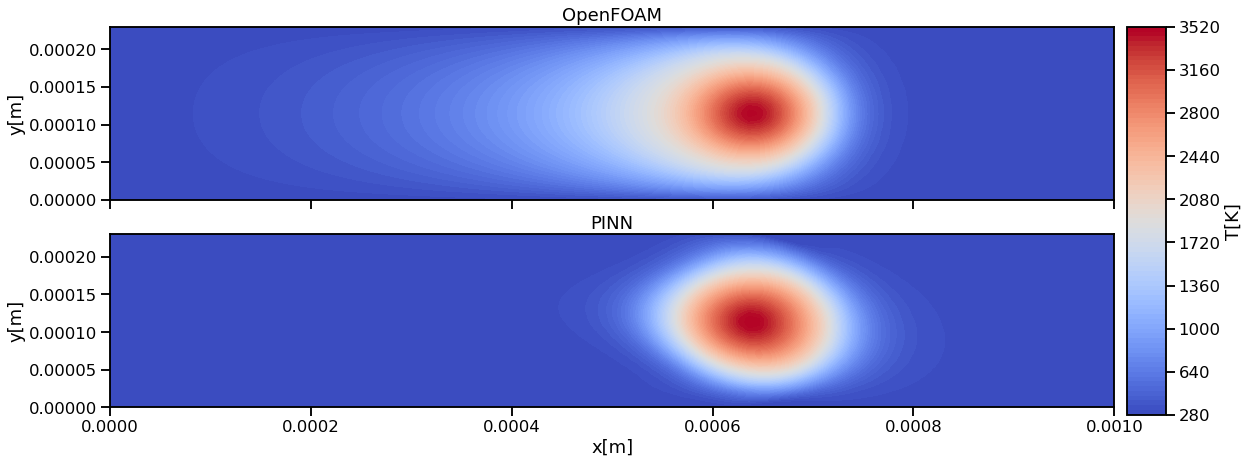

In [116]:
i = 199
dt = t_max/200
end_data = np.genfromtxt('of_test/slices/slice_dat_{}.csv'.format(i), delimiter = ',',skip_header = True)

#end_data = np.genfromtxt('of_test/end_slice.csv', delimiter = ',',skip_header = True)
x, y, z, T = end_data[:, 0], end_data[:, 1], end_data[:, 2], end_data[:, 3]

fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (18, 7), sharex=True)

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')

ax1.set_ylabel('y[m]')
ax1.set_title('OpenFOAM')
ax2.set_ylabel('y[m]')
ax2.set_xlabel('x[m]')
ax2.set_title('PINN')

#cbar = plt.colorbar(im, ax = ax1)
#cbar.ax.set_ylabel('T[K]')
#cbar2 = plt.colorbar(im, ax = ax2)
#cbar2.ax.set_ylabel('T[K]')

X = np.vstack((x, y, np.ones(len(x))*z.max(), np.ones(len(x))*dt*i)).T
Y = model.predict(X)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
T_pred = griddata((x, y), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')
    
im = ax1.contourf(xi, yi, Ti, 100, cmap=plt.cm.coolwarm, vmin = T.min(), vmax = T.max())
CS = ax2.contourf(xi, yi, T_pred, 100, cmap=plt.cm.coolwarm, vmin = T.min(), vmax = T.max())

cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('T[K]')
plt.show()

Text(0, 0.5, 'T[K]')

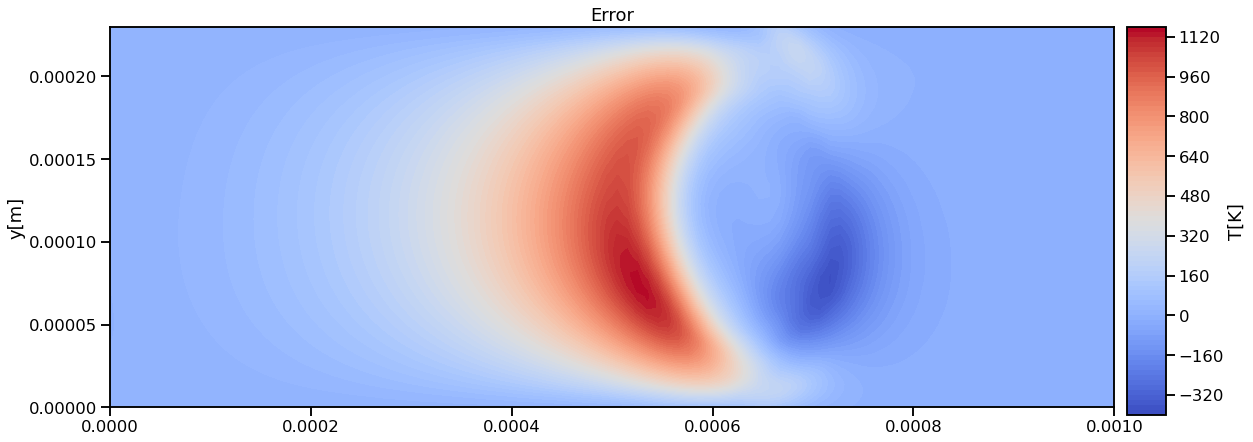

In [112]:
fig, (ax1) = plt.subplots(ncols = 1, nrows = 1, figsize = (18, 7))

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')

ax1.set_ylabel('y[m]')
ax1.set_title('Error')
ax2.set_ylabel('y[m]')
ax2.set_xlabel('x[m]')
ax2.set_title('PINN')

#cbar = plt.colorbar(im, ax = ax1)
#cbar.ax.set_ylabel('T[K]')
#cbar2 = plt.colorbar(im, ax = ax2)
#cbar2.ax.set_ylabel('T[K]')

#X = np.vstack((x, y, np.ones(len(x))*z.max(), np.ones(len(x))*t_max)).T
#Y = model.predict(X)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
T_pred = griddata((x, y), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')
    
im = ax1.contourf(xi, yi, Ti - T_pred, 100, cmap=plt.cm.coolwarm)

cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('T[K]')

In [83]:
T_pred.shape

(100, 100)

In [84]:
T.shape

(2196,)

In [ ]:
y.max()

In [ ]:
x_max

In [ ]:
y_max

In [ ]:
z_max

In [113]:
T.max()

3473.9

In [114]:
T_pred.max()

3508.0716751345835

In [85]:
t_lin

array([0.        , 0.00022222, 0.00044444, 0.00066667, 0.00088889,
       0.00111111, 0.00133333, 0.00155556, 0.00177778, 0.002     ])

In [86]:
X

array([[2.5667e-05, 0.0000e+00, 1.0000e-04, 2.0000e-03],
       [0.0000e+00, 0.0000e+00, 1.0000e-04, 2.0000e-03],
       [2.5667e-05, 6.5714e-06, 1.0000e-04, 2.0000e-03],
       ...,
       [1.4887e-03, 2.3000e-04, 1.0000e-04, 2.0000e-03],
       [1.5143e-03, 2.3000e-04, 1.0000e-04, 2.0000e-03],
       [1.5400e-03, 2.3000e-04, 1.0000e-04, 2.0000e-03]])

In [15]:
T_pred.max()

6091.085075471046

In [71]:
2700/60

45.0